In [2]:
!pip install kaggle

You should consider upgrading via the '/Users/lucaswerner/Desktop/hands-on-machine-learning/.env/bin/python3.9 -m pip install --upgrade pip' command.


In [3]:
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
import os
from pathlib import Path
path_to_zip = Path(os.getcwd(),'titanic.zip')

with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
	os.mkdir(os.path.join(os.getcwd(),'dataset'))
	zip_ref.extractall(Path(os.getcwd(),'dataset'))

if Path(os.getcwd(),'dataset','gender_submission.csv').exists():
	os.remove(os.path.join(os.getcwd(),'dataset','gender_submission.csv'))

FileExistsError: [Errno 17] File exists: '/Users/lucaswerner/Desktop/hands-on-machine-learning/experiments/chapter_03/dataset'

In [5]:
import pandas as pd

train = pd.read_csv('dataset/train.csv')
x_test = pd.read_csv('dataset/test.csv')

In [6]:
x_train, y_train = train.drop(['Survived'],axis=1), train['Survived']
assert x_train.shape == (train.shape[0],train.shape[1]-1)
assert y_train.shape == (train.shape[0],)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
columns_na = train.isna().any().loc[lambda x: x==True]

In [10]:
columns_na.index.to_list()

['Age', 'Cabin', 'Embarked']

In [11]:
print(f'Without dropping NaN: {x_train.shape}, after dropping NaN: {x_train.dropna(axis=1).shape}')

Without dropping NaN: (891, 11), after dropping NaN: (891, 8)


In [12]:
x_train['Embarked'].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [13]:
x_train[(x_train['Embarked'].isnull()) | (x_train['Embarked'] == 'Q')]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
16,17,3,"Rice, Master. Eugene",male,2.0,4,1,382652,29.1250,NaN,Q
22,23,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
28,29,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
32,33,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
825,826,3,"Flynn, Mr. John",male,NaN,0,0,368323,6.9500,NaN,Q
828,829,3,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,367228,7.7500,NaN,Q
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0000,B28,NaN
885,886,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q


array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

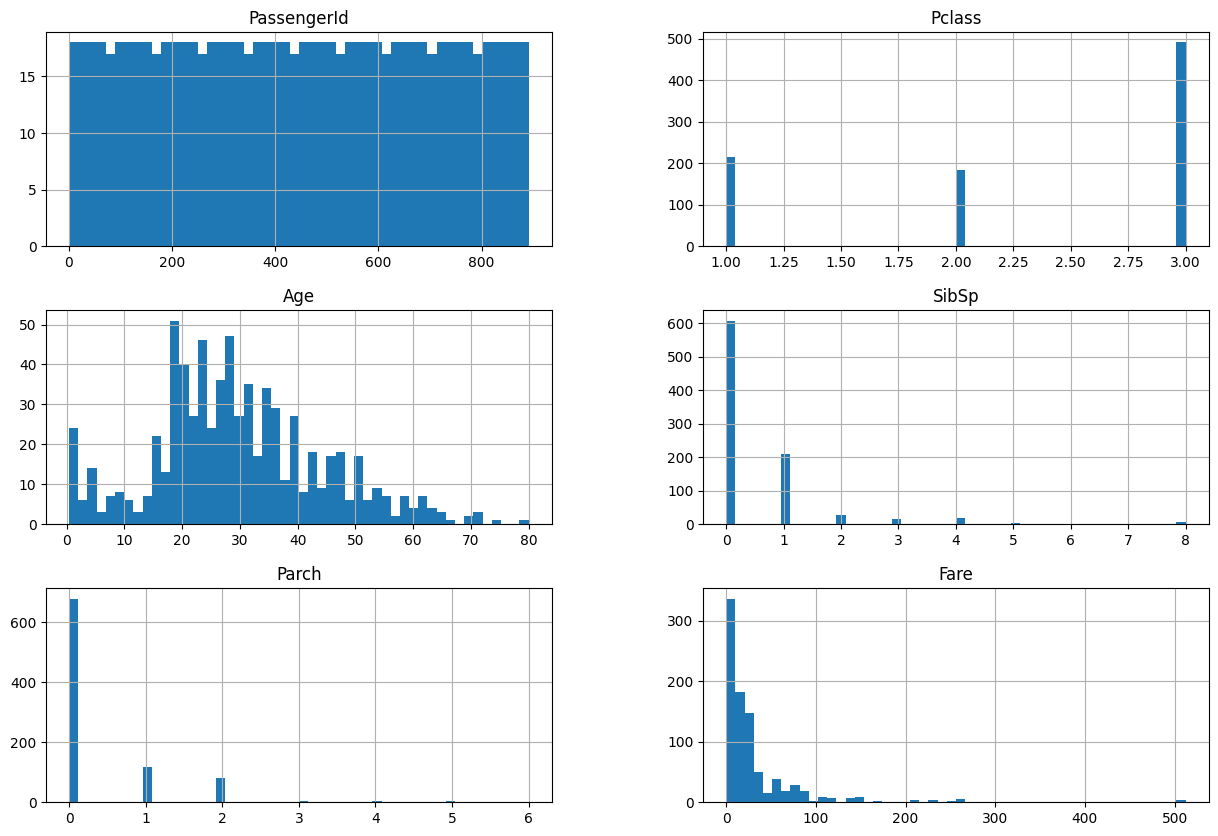

In [14]:
x_train.hist(bins=50,figsize=(15,10))

In [15]:
survivors_orphans = x_train[(x_train['Parch'] == 0) & ((x_train['SibSp'] == 0))].index
y_train.iloc[survivors_orphans].value_counts()

0    374
1    163
Name: Survived, dtype: int64

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropColumnTransformer(BaseEstimator, TransformerMixin):
    """
    DropColumnTransformer Drop unnecessary columns

    Use the drop column transformer to delete the passenger ID and the
    name which are unlikely to be useful while predicting the survival of
    a passenger.

    Args:
        BaseEstimator (_type_): _description_
        TransformerMixin (_type_): _description_
    """
    def __init__(self):
        pass
    
    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X:pd.DataFrame):
        return X.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)

In [17]:
x_train.select_dtypes(include=[object]).columns

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

In [18]:
x_train[['Cabin','Pclass']].sort_values(by='Cabin',ascending=True,)

,Cabin,Pclass
583,A10,1
475,A14,1
556,A16,1
284,A19,1
599,A20,1
...,...,...
884,NaN,3
885,NaN,3
886,NaN,2
888,NaN,3


In [19]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
x_train_one_hot = cat_encoder.fit_transform(x_train)

In [20]:
x_train_one_hot

<891x2971 sparse matrix of type '<class 'numpy.float64'>'
	with 9801 stored elements in Compressed Sparse Row format>

In [100]:
from sklearn.pipeline import make_pipeline

drop_pipeline = make_pipeline(
    DropColumnTransformer()
)

x_train = drop_pipeline.fit_transform(x_train)

KeyError: "['PassengerId', 'Name', 'Ticket', 'Cabin'] not found in axis"

In [101]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore'),
    )

num_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)




In [105]:
x_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [102]:
x_train.iloc[0]

Pclass         3
Sex         male
Age         22.0
SibSp          1
Parch          0
Fare        7.25
Embarked       S
Name: 0, dtype: object

In [106]:
preprocessing = ColumnTransformer([
    ("categorical_columns",cat_pipeline,['Pclass','Sex','Embarked']),
    ("num_columns",num_pipeline, ['Age','SibSp','Parch','Fare'])]
)

In [107]:
test = preprocessing.fit_transform(x_train)

In [111]:
preprocessing.get_feature_names_out()

array(['categorical_columns__Pclass_1', 'categorical_columns__Pclass_2',
       'categorical_columns__Pclass_3', 'categorical_columns__Sex_female',
       'categorical_columns__Sex_male', 'categorical_columns__Embarked_C',
       'categorical_columns__Embarked_Q',
       'categorical_columns__Embarked_S', 'num_columns__Age',
       'num_columns__SibSp', 'num_columns__Parch', 'num_columns__Fare'],
      dtype=object)

In [123]:
from sklearn.ensemble import RandomForestClassifier

lin_reg = make_pipeline(preprocessing)

X_train_processed = lin_reg.fit_transform(x_train)

In [129]:
forest_clf = RandomForestClassifier(n_estimators=100,random_state=42)
forest_clf.fit(X_train_processed, y_train)

RandomForestClassifier(random_state=42)

In [130]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(forest_clf,X_train_processed,y_train,cv=10)

In [131]:
scores.mean()

0.8126342072409487